In [2]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import joblib

In [3]:
training_file_names = pd.read_csv('may_3_feature_files.txt', sep='\n', header=None)[0].tolist()

In [4]:
len(training_file_names)

169

In [5]:
def extract_rna_type(name):
    return re.sub(" ", "_", re.search("rna_type.*_dataset", name).group(0)[9:-8])

In [6]:
dfs = []
for i, filename in enumerate(training_file_names):
    rna_type = extract_rna_type(filename)
    df = pd.read_csv(filename)
    df['label'] = rna_type
    dfs.append(df)
final_df = pd.concat(dfs)

In [7]:
def filter_cluster_df(df, seqCount_filter=True, classes = ['hairpin_miRNA', 'isomiR_miRNA', 'mRNA', 'mature_tRNA', 'primary_tRNA', 'rRNA', 'snoRNA']):
    if seqCount_filter:
        df1 = df[np.logical_and(df['seqCount'] > 2, df['readCountSum'] > 9)]
    df2 = df[df['label'].isin(classes)]
    return df2

In [8]:
def add_miRNA_yes_no(row):
    if 'miRNA' in row['label']:
        row['miRNA'] = True
    else:
        row['miRNA'] = False
    return row

In [9]:
filtered_df = filter_cluster_df(final_df, seqCount_filter=True).apply(add_miRNA_yes_no, axis=1)

In [11]:
filtered_df.to_csv('filtered_feature_df.csv', index=None)

# Clean the data frame before training the SVM
1. Remove two empty columns (realMicRNA and realMicRNAName) and the clusterName
2. One hot encoding
3. Standardize the remaining entries. 

We can find exactly what to do in their model_predict function. 

In [11]:
def subsample_for_balance(df, size_of_df=10**5):
    positives = df[df['miRNA']]
    negatives = df[~df['miRNA']]
    if len(positives) <= len(negatives):
        subsampled_negs = negatives.sample(min([len(positives), size_of_df/2]))
        subsampled_pos = positives.sample(min([len(positives), size_of_df/2]))
        return pd.concat([positives, subsampled_negs])
    else:
        subsampled_pos = positives.sample(len(negatives))
        return pd.concat([subsampled_pos, negatives])
    
def standardize(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

In [12]:
balanced_df = subsample_for_balance(filtered_df)

In [13]:
X = standardize(pd.get_dummies(balanced_df.iloc[:, 3:-2]))
y = balanced_df['miRNA']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                        X, y,
                test_size = 0.20, random_state = 101)

In [15]:
X_train.shape

(4051, 103)

In [16]:
X_test.shape

(1013, 103)

In [17]:
# defining parameter range
param_range = 10**np.arange(-4, 4, dtype=float)
param_grid = {'C': param_range,
              'gamma': param_range,
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [18]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Note that if the best parameter values are on the edge of the grid, we should probably refit!

In [19]:
grid_predictions = grid.predict(X_test)

In [20]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

       False       0.89      0.83      0.86       506
        True       0.84      0.90      0.87       507

    accuracy                           0.86      1013
   macro avg       0.87      0.86      0.86      1013
weighted avg       0.87      0.86      0.86      1013



In [21]:
grid.best_estimator_.n_support_

array([1036, 1132], dtype=int32)

# Try their trained model on some of this test data

In [ ]:
sc, clf, selectFeatureNameList = joblib.load(modelFile)

In [28]:
pre_trained = {}

In [29]:
tmp = joblib.load('mirge/models/human_svc_model.pkl')

/home/jfernand/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jfernand/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/jfernand/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [35]:
balanced_df

,realMicRNA,realMicRNAName,clusterName,seqCount,readCountSum,exactMatchRatio,headUnstableLength,tailUnstableLength,head_minus3_templateNucleotide,head_minus3_TemplateNucleotide_percentage,...,binding_count,interiorLoopCount,apicalLoop_size,stem_length,mFE,count_bindings_in_miRNA,UGU_UGUG_motif,pair_state,label,miRNA
0,Null,Null,ERR038413:miRCluster_13_16:chr1:10978127_10978...,5,13,0.230769,0,4,G,0.0,...,12,2,3,12,-14.2,10,No,No,isomiR_miRNA,True
1,Null,Null,ERR038413:miRCluster_1_18:chr1:19612962_19612979+,125,932,0.002146,0,3,T,0.0,...,8,1,20,8,-7.7,5,Yes,No,isomiR_miRNA,True
2,Null,Null,ERR038413:miRCluster_4_16:chr1:38063060_38063075+,30,159,0.031447,1,1,T,0.0,...,19,5,7,19,-20.7,5,No,No,isomiR_miRNA,True
3,Null,Null,ERR038413:miRCluster_6_19:chr1:71426873_71426891+,197,2889,0.263759,2,5,T,0.0,...,12,2,8,12,-8.8,6,Yes,No,isomiR_miRNA,True
4,Null,Null,ERR038413:miRCluster_7_16:chr1:74453510_74453525+,3,11,0.454545,0,1,A,0.0,...,26,4,6,26,-15.6,9,No,No,isomiR_miRNA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Null,Null,ERR038413:miRCluster_94_25:chr11:109412882_109...,144,5704,0.013850,0,7,T,0.0,...,17,2,7,17,-12.5,8,No,No,mature_tRNA,False
16,Null,Null,SRR837839:miRCluster_28_17:chr1:237699895_2376...,6,26,0.076923,5,3,T,1.0,...,24,5,9,24,-14.6,11,No,No,rRNA,False
109,Null,Null,ERR973611:miRCluster_65_16:chr4:145937893_1459...,14,99,0.101010,2,3,A,0.0,...,20,3,13,20,-22.3,9,No,No,rRNA,False
197,Null,Null,ERR973613:miRCluster_148_26:chr6:132816804_132...,18,268,0.977612,1,8,G,0.0,...,25,5,14,25,-23.7,12,No,Yes,snoRNA,False


In [ ]:
totalfeatureList = balanced_df.columns.values.tolist()
subIndexList = [totalfeatureList.index(item[2]) for item in selectFeatureNameList]
data_x = data.iloc[:,subIndexList].values
x_test_std_new = sc.transform(data_x)
#featureLabel_new = subIndexList
x_test_std_new2 = x_test_std_new
predictedValue = clf.predict(x_test_std_new2)

In [30]:
pre_trained['sc'] = tmp[0]
pre_trained['clf'] = tmp[1]
pre_trained['selectFeatureNameList'] = tmp[2]

In [31]:
pre_trained['clf'].predict(X_test)

ValueError: X.shape[1] = 103 should be equal to 21, the number of features at training time

# Diagnostics
~~The SVM predicted all False. Is this because you didn't standardize your y variable? I don't think so...~~ RESOLVED

OTHER DIAGNOSTICS: We can do a PCA on features, we can think about support vectors, we can do all a manner of things. We could do an SVM after PCA? 

(-1, 1)

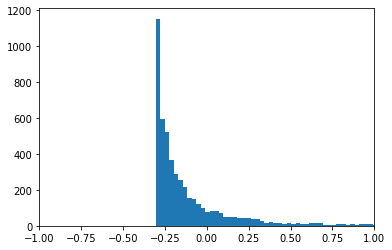

In [22]:
plt.hist(X[:, 0], bins="auto");
plt.xlim(-1, 1)

This is not a normal distribution... What is the mean and standard deviation? 

In [24]:
X.shape

(5064, 103)

In [25]:
print('mean', np.mean(X, axis=0));
print('standard_deviation', np.std(X, axis=0));

mean [ 1.12250037e-17  2.80625093e-18  0.00000000e+00 -8.98000298e-17
  1.12250037e-17  8.98000298e-17  5.61250186e-18 -1.12250037e-17
 -2.24500074e-17 -1.12250037e-17 -4.49000149e-17  1.68375056e-17
  3.36750112e-17  2.24500074e-17 -2.24500074e-17  8.98000298e-17
  1.40312547e-17  1.12250037e-17  2.24500074e-17 -1.61359429e-17
  1.79600060e-16  3.36750112e-17  3.36750112e-17 -1.68375056e-17
  1.12250037e-17  1.12250037e-16 -1.01025034e-16  0.00000000e+00
 -2.24500074e-17  1.68375056e-17 -2.24500074e-17 -2.24500074e-17
  6.17375205e-17 -6.87531478e-17  2.24500074e-17  2.24500074e-17
 -1.12250037e-17 -3.08687602e-17  8.41875279e-18  0.00000000e+00
  2.24500074e-17 -1.12250037e-17 -1.68375056e-17  1.12250037e-17
 -8.41875279e-18 -4.49000149e-17 -5.61250186e-18  2.80625093e-18
  2.24500074e-17 -1.68375056e-17 -2.80625093e-17 -7.01562733e-18
 -8.41875279e-17 -2.80625093e-17  0.00000000e+00 -7.57687751e-17
  9.54125317e-17 -1.12250037e-16 -8.83969043e-17  5.89312696e-17
  3.36750112e-17  3.

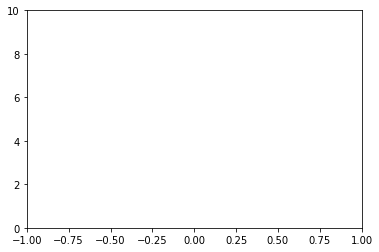

In [26]:
plt.hist(balanced_df[balanced_df['miRNA']]['seqCount'], bins='auto');
plt.xlim(-1, 1);
plt.ylim(0, 10);

???

# Another fit
In order to try to catch the edge of parameter space

In [179]:
param_range = 10**np.arange(-8, 0, dtype=float)

In [180]:
param_range

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [ ]:
# defining parameter range
param_range = 10**np.arange(-8, 0, dtype=float)
param_grid = {'C': param_range,
              'gamma': param_range,
              'kernel': ['rbf']}

grid_80 = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
 
# fitting the model for grid search
grid_80.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


~~# The exact same number of clusters was found for each type in each sample? 
I am very suspicious...~~ RESOLVED

In [71]:
example_mapped = pd.read_csv("/home/jfernand/mirge/miRge3.0-feature-extraction/output_dir/miRge.2022-05-01_00-38-13/mapped.csv")

for col in example_mapped.columns[2:-1]:
    print(col)
    print(len(example_mapped[~example_mapped[col].isna()]))

FileNotFoundError: [Errno 2] File /home/jfernand/mirge/miRge3.0-feature-extraction/output_dir/miRge.2022-05-01_00-38-13/mapped.csv does not exist: '/home/jfernand/mirge/miRge3.0-feature-extraction/output_dir/miRge.2022-05-01_00-38-13/mapped.csv'

In [30]:
example_mapped = pd.read_csv("/home/jfernand/mirge/miRge3.0-feature-extraction/output_dir/miRge.2022-05-01_00-38-13/mapped.csv")

In [34]:
for col in example_mapped.columns[2:-1]:
    print(col)
    print(len(example_mapped[~example_mapped[col].isna()]))

exact miRNA
1125
hairpin miRNA
51
mature tRNA
597
primary tRNA
10
snoRNA
222
rRNA
8134
ncrna others
1054
mRNA
211
isomiR miRNA
14223


So mapped.csv looks fine

In [43]:
col

'isomiR miRNA'

In [45]:
ismoiR = example_mapped[~example_mapped[col].isna()]

In [48]:
print(example_mapped.head())

                      Sequence  annotFlag        exact miRNA hairpin miRNA  \
0       TTCAANAAATTCAGGATAGGTT          1                NaN           NaN   
1      TAGCACCATCTGAAATCGGTTAT          1  Hsa-Mir-29-P1a_3p           NaN   
2    TGAGGTAGTAGGTTGTATAGTTTCT          1                NaN           NaN   
3  TTCAAGTAATCCAGGATAGGCTTTCTC          1                NaN           NaN   
4   TCCCTGAGACCCTAACTTGTGATCTC          1                NaN           NaN   

  mature tRNA primary tRNA snoRNA rRNA ncrna others mRNA       isomiR miRNA  \
0         NaN          NaN    NaN  NaN          NaN  NaN   Hsa-Mir-26-P3_5p   
1         NaN          NaN    NaN  NaN          NaN  NaN                NaN   
2         NaN          NaN    NaN  NaN          NaN  NaN    Hsa-Let-7-P7_5p   
3         NaN          NaN    NaN  NaN          NaN  NaN   Hsa-Mir-26-P1_5p   
4         NaN          NaN    NaN  NaN          NaN  NaN  Hsa-Mir-10-P3b_5p   

   SRR2174517  
0           1  
1          57  
2       

In [38]:
final_df[final_df['clusterName'].str.contains('SRR2174517')].groupby('label').count()

,realMicRNA,realMicRNAName,clusterName,seqCount,readCountSum,exactMatchRatio,headUnstableLength,tailUnstableLength,head_minus3_templateNucleotide,head_minus3_TemplateNucleotide_percentage,...,percentage_PairedInMiRNA,hairpin_count,binding_count,interiorLoopCount,apicalLoop_size,stem_length,mFE,count_bindings_in_miRNA,UGU_UGUG_motif,pair_state
label,,,,,,,,,,,,,,,,,,,,,
hairpin_miRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
isomiR_miRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
mRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
mature_tRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
ncrna_others,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
primary_tRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
rRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93
snoRNA,93,93,93,93,93,93,93,93,93,93,...,93,93,93,93,93,93,93,93,93,93


Hypothesis: I think we're probably feeding in the same dataframe to novel_mir.py every time, rather than filtering correctly for is.na in mapped.

The code looks right, but actually they're not "na", they're blank! So it IS PASSING THE SAME DATA FRAME EVERY TIME WHICH IS HUGE FOR US! 